# Kaggle : New York City Taxi Trip Duration

<img src="taxi.png">

# 1 EDA (Exploratory Data Analysis)

# purpose of  EDA

- Suggest hypotheses about the causes of observed phenomena
- Assess assumptions on which statistical inference will be based
- Support the selection of appropriate statistical tools and techniques
- Provide a basis for further data collection through surveys or experiments

# EDA methods
- Graphical techniques used in EDA are:
    - boxplot 
        - detailed feature (datetime by month, day of week, hours)
    - historgram or barplot (distribution) # bin = range of value
        - origin feature (pick lat,long, drop lat, long, duration, passenger count, flag)
        - detailed feature (datetime by month, day of week, hours)
    - scatter plot
        - duration vs distance = to check odd data
    - Parallel Coordinates vs Colormaps vs Andrews curves charts
    - odd ratio????

- Quantative methods:
    - Trimean == tukey method?

# 1.1 Understanding data 

In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import seaborn as sns
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy.stats import norm, skew 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/home/jk/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test = pd.read_csv("test.csv")
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [71]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


# 1.1.a Data type and unit

# unit

### 1. latitude / longtitude = decimal degree 
- 111.32mm per 0.000001° / 11.132 m per 0.0001° / 1.1132 km per 0.01° / 111.32 km per 1.0°
- 14 demical degree
- ex) 40.767937 , -73.982155

### 2. datetime = year-month-day: hour-minute-second

### 3. vendor_id = 1, 2

### 4. passenger_count = 0 - 9

### 4. store_and_fwd_flag = N, Y

### 6. duration = second
- ex) 455 sec = 7min 35sec


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


# train data
-  1.4M data, 11 columns

# test data
-  0.6M data, 9 columns (no dropoff_datetime, trip_duration)

# 1.1.b Missing Data check

In [6]:
#none of missing data
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

# 1.1.c Trip duration

# trip duration calculation validation

In [8]:
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
train["dropoff_datetime"] =  pd.to_datetime(train["dropoff_datetime"])
sample_duration = train["dropoff_datetime"] - train["pickup_datetime"]
sample_duration_sec = sample_duration.dt.total_seconds().astype('int')
train['trip_sec'] =  sample_duration_sec

In [9]:
train_d = train[train["trip_duration"] != train["trip_sec"]]
print(len(train_d))

if len(train_d) == 0:
    train = train.drop(['trip_sec'], axis=1)

0


# drop odd data

In [10]:
#drop 100,000 duration time data
print(len(train.loc[train.trip_duration > 100000]))

4


In [11]:
print("before drop : ", len(train))
train = train[train["trip_duration"] < 100000]
print("after  drop : ", len(train))

before drop :  1458644
after  drop :  1458640


# trip duration visualization

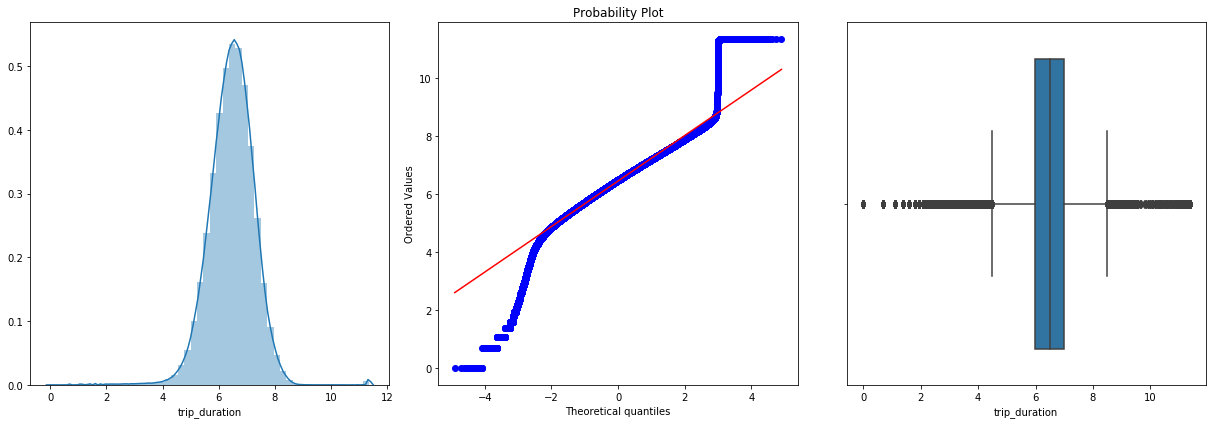

count    1.458640e+06
mean     9.528153e+02
std      3.171322e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      8.639200e+04
Name: trip_duration, dtype: float64 

Skewness: 25.268663
Kurtosis: 666.967537


In [12]:
#logigramatic trip duration data
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log(train["trip_duration"]))

plt.subplot(132)
stats.probplot(np.log(train["trip_duration"]), plot=plt)

plt.subplot(133)
sns.boxplot(np.log(train["trip_duration"]))
plt.tight_layout()
plt.show()

print(train["trip_duration"].describe(),"\n")

print("Skewness: %f" % train['trip_duration'].skew())
print("Kurtosis: %f" % train['trip_duration'].kurt())

# 1.2 Feature Engineering & Data Cleaning

# date time convert

In [13]:
train = train.drop("dropoff_datetime", axis=1)

In [14]:
#data type convert to datetime from object
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
test["pickup_datetime"] =  pd.to_datetime(test["pickup_datetime"])

In [15]:
#day of week
#Monday=0, Sunday=6
train["pick_dayofweek"] = train["pickup_datetime"].dt.dayofweek
test["pick_dayofweek"] = test["pickup_datetime"].dt.dayofweek

In [16]:
train["pick_month"] = train["pickup_datetime"].apply(lambda x : x.month)
train["pick_day"] = train["pickup_datetime"].apply(lambda x : x.day)
train["pick_hour"] = train["pickup_datetime"].apply(lambda x : x.hour)
# train["pick_min"] = train["pickup_datetime"].apply(lambda x : x.minute)
# train["pick_sec"] = train["pickup_datetime"].apply(lambda x : x.second)

test["pick_month"] = test["pickup_datetime"].apply(lambda x : x.month)
test["pick_day"] = test["pickup_datetime"].apply(lambda x : x.day)
test["pick_hour"] = test["pickup_datetime"].apply(lambda x : x.hour)
# test["pick_min"] = test["pickup_datetime"].apply(lambda x : x.minute)
# test["pick_sec"] = test["pickup_datetime"].apply(lambda x : x.second)

In [17]:
# train = train.drop('pickup_datetime', axis=1)
# test = test.drop('pickup_datetime', axis=1)

In [18]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pick_dayofweek,pick_month,pick_day,pick_hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,14,17
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,12,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,19,11
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,4,6,19
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,3,26,13


# national holiday

In [19]:
from bs4 import BeautifulSoup
import requests 
import urllib.request

In [20]:
#wrapper > div:nth-child(3) > div.twelve.columns > table.list-table > tbody > tr:nth-child(2) > td:nth-child(2)

In [21]:
df = pd.DataFrame(columns=["rank","keyword"])
response = requests.get("https://www.officeholidays.com/countries/usa/2016.php")
bs = BeautifulSoup(response.content, "html.parser")
trs = bs.select("table td")
trs1 = trs[1::5]

In [22]:
li = []
holi = pd.DataFrame()
count = 0

for i in trs1[0:14]:
    li.append((i.text).strip())
    li[count] = '2016 ' + li[count]
    li[count] = li[count].split(" ")
    li[count] = li[count][0] + "-" + li[count][1] + '-' + li[count][2]
    count += 1 

holi['date'] = li 
holi['date'] = pd.to_datetime(holi['date'])
holi

,date
0,2016-01-01
1,2016-01-18
2,2016-02-15
3,2016-04-15
4,2016-05-08
5,2016-05-30
6,2016-06-19
7,2016-07-04
8,2016-09-05
9,2016-10-10


In [23]:
select_date = list(holi["date"].astype("str"))
holiday = train.pickup_datetime.apply(lambda x : str(x.date())).isin(select_date)
train["holiday"] = holiday

In [24]:
select_date = list(holi["date"].astype("str"))
holiday = test.pickup_datetime.apply(lambda x : str(x.date())).isin(select_date)
test["holiday"] = holiday

In [25]:
train['holiday'] = 1 * (train.holiday == True)
test['holiday'] = 1 * (test.holiday == True)

# New York City Weather Event 

In [26]:
from selenium import webdriver

In [27]:
driver =  webdriver.PhantomJS()    
driver.get("https://www.weather.gov/okx/stormevents")

In [28]:
date = driver.find_elements_by_css_selector('#pagebody > div:nth-child(3) > div > table > tbody > tr > td ul:nth-child(6)')
lis = date[0].find_elements_by_css_selector('li')

In [29]:
li_wea = []
count = 0

rows=[]
for i in lis:
    li_wea.append(i.text)
    li_wea[count] = '2016 ' + li_wea[count]
    li_wea[count] = li_wea[count].split(" ")

    li_wea[count] = li_wea[count][0] + "-" + li_wea[count][1] + "-" + li_wea[count][2] + "-" + li_wea[count][3]
#     rows.append([li_wea[count][0], li_wea[count][1], li_wea[count][2] ,li_wea[count][3]])
    count += 1 

    
#rows

In [30]:
new1 = pd.DataFrame(li_wea, columns=['old'])
new1['date'] = new1['old'].str.extract('(\d\d\d\d-...-\d\d)', expand=True)

In [31]:
new1['date'][4] = '2016-Feb-05'
new1['date'][5] = '2016-Feb-08'
new1['date'][11] = '2016-Apr-03'
new1['date'][12] = '2016-Apr-04'
new1['date'][14] = '2016-June-28'
new1['date'][15] = '2016-July-18'
new1['date'][16] = '2016-July-29'
new1['date'][17] = '2016-July-31'
new1['date'][25] = '2016-Oct-08'
new1['date'][35] = '2016-Dec-05'
new1 = new1.drop('old', axis=1)

In [32]:
new2 = pd.DataFrame(['2016-August-01', '2016-Dec-01'], columns=['date'])
new1 = new1.append(new2, ignore_index=True).dropna()
new1['date'] = pd.to_datetime(new1['date'])
new1

,date
0,2016-01-10
1,2016-01-13
2,2016-01-17
3,2016-01-23
4,2016-02-05
5,2016-02-08
6,2016-02-15
7,2016-02-24
8,2016-03-14
9,2016-03-21


In [33]:
select_date = list(new1["date"].astype("str"))
weather = train.pickup_datetime.apply(lambda x : str(x.date())).isin(select_date)
train["weather"] = weather

In [34]:
select_date = list(new1["date"].astype("str"))
weather = test.pickup_datetime.apply(lambda x : str(x.date())).isin(select_date)
test["weather"] = weather

In [35]:
train['weather'] = 1 * (train.weather == True)
test['weather'] = 1 * (test.weather == True)

In [36]:
driver.close()

# 1.2.b Distance between pickup and dropoff location

# uclidean Distance

In [37]:
def uclidean(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    R = 6371.0
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * R * np.arcsin(np.sqrt(d))
    return h

In [38]:
train['uclidean'] = uclidean(train.pickup_latitude, train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)
test['uclidean'] = uclidean(test.pickup_latitude, test.pickup_longitude, test.dropoff_latitude, test.dropoff_longitude)

# manhatan distance

In [39]:
train['manhatan'] = (abs(train.dropoff_longitude - train.pickup_longitude) + abs(train.dropoff_latitude - train.pickup_latitude)) * 113.2
test['manhatan'] = (abs(test.dropoff_longitude - test.pickup_longitude) + abs(test.dropoff_latitude - test.pickup_latitude)) * 113.2

## direction

In [40]:
def direction(pickup_lat, pickup_long, dropoff_lat, dropoff_long):

    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * np.sin(dropoff_lat_rads) - np.sin(pickup_lat_rads) * np.cos(dropoff_lat_rads) * np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [41]:
train['direction'] = direction(train.pickup_latitude, train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)
test['direction'] = direction(test.pickup_latitude, test.pickup_longitude, test.dropoff_latitude, test.dropoff_longitude)

# 1.2.d.2 Spatial Data Analysis

### Types of spatial analysis
- FA(factor analysis)
    - Euclidean metric = > PCA(principal component analysis)
    - Chi-Square distance => Correspondence Analysis (similar to PCA, but better for categrorical data)
    - Generalized Mahalanobis distance => Discriminant Analysis 

### stack-up coordinates data

In [42]:
coord_pick_lat = pd.concat([train['pickup_latitude'], test['pickup_latitude']], axis=0)
coord_pick_lon = pd.concat([train['pickup_longitude'], test['pickup_longitude']], axis=0)
coord_drop_lat = pd.concat([train['dropoff_latitude'], test['dropoff_latitude']], axis=0)
coord_drop_lon = pd.concat([train['dropoff_longitude'], test['dropoff_longitude']], axis=0)

coord_pick = pd.concat([coord_pick_lat, coord_pick_lon], axis=1)
coord_drop = pd.concat([coord_drop_lat, coord_drop_lon], axis=1)

coord_lat = pd.concat([train['pickup_latitude'], train['dropoff_latitude'], test['pickup_latitude'], test['dropoff_latitude']], axis=0)
coord_lon = pd.concat([train['pickup_longitude'], train['dropoff_longitude'], test['pickup_longitude'], test['dropoff_longitude']], axis=0)
coord_all = pd.concat([coord_lat, coord_lon], axis=1)
coord_all.columns = ['lat', 'lon']

# coordinates scatter plot

In [43]:
# new york city coordinate = (41.145495, −73.994901)
city_lon_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

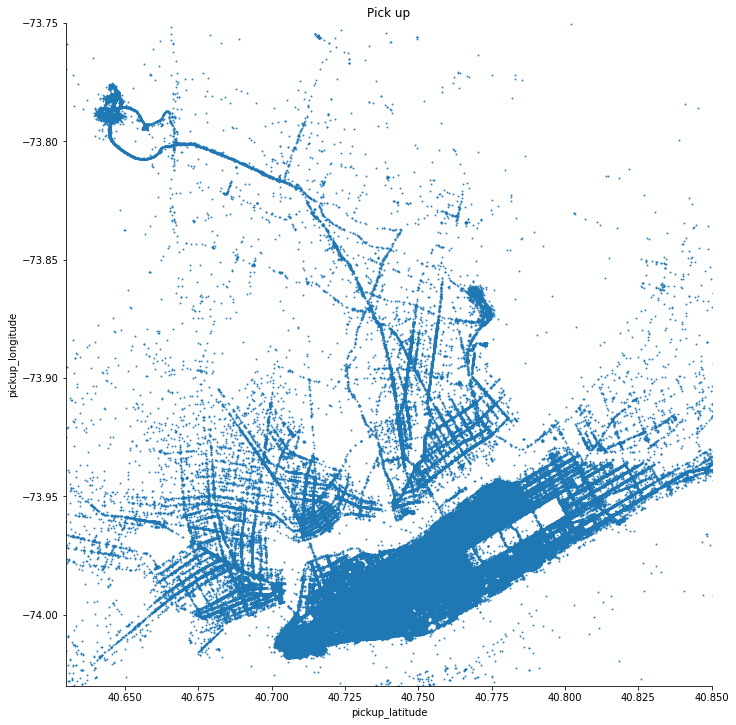

In [44]:
sns.lmplot(x='pickup_latitude', y='pickup_longitude', data=coord_pick, fit_reg=False, scatter_kws={"s": 1}, size=10)
plt.ylim(city_lon_border)
plt.xlim(city_lat_border)
plt.title('Pick up')
plt.show()

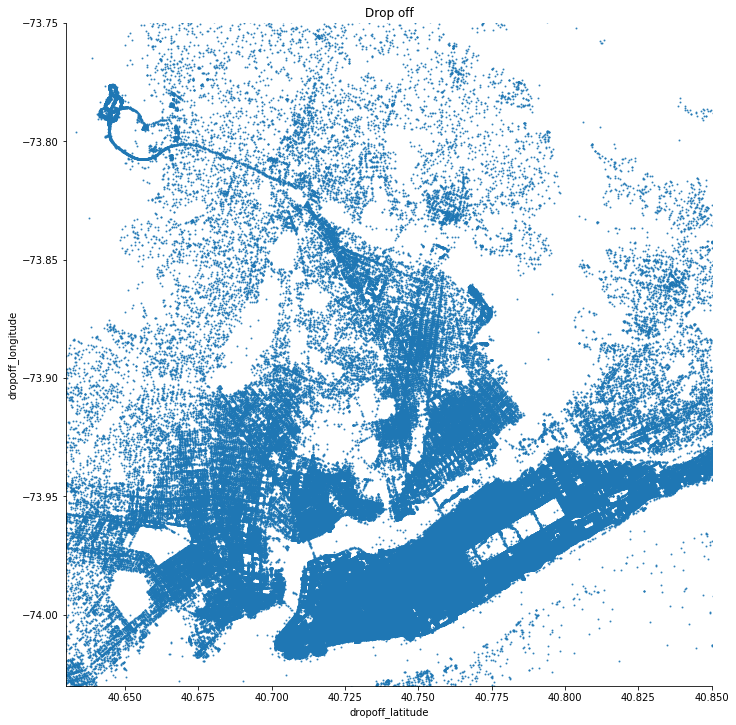

In [45]:
sns.lmplot(x='dropoff_latitude', y='dropoff_longitude', data=coord_drop, fit_reg=False, scatter_kws={"s": 1}, size=10)
plt.ylim(city_lon_border)
plt.xlim(city_lat_border)
plt.title('Drop off')
plt.show()

# PCA

In [46]:
pca = PCA(random_state=0).fit(coord_all)

In [47]:
# train['pca_lat0'] = pca_lat.transform(train[['pickup_latitude']])[:, 0]

In [48]:
#PCA
train['pick_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pick_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['drop_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['drop_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pick_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pick_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['drop_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['drop_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [49]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,pick_hour,holiday,weather,uclidean,manhatan,direction,pick_pca0,pick_pca1,drop_pca0,drop_pca1
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,17,0,1,1.498521,2.248074,174.333195,0.007691,0.017053,-0.009667,0.013695
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,0,0,0,1.805507,2.997289,-178.051506,0.007677,-0.012371,0.027145,-0.018652
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,11,0,0,6.385098,9.073912,-179.629721,0.004803,0.012879,0.034222,-0.039337
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,19,0,0,1.485498,1.752341,-179.872566,0.038342,-0.029194,0.041343,-0.042293
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,13,0,0,1.188588,1.224652,179.990812,-0.002877,0.041748,-0.002380,0.031070


# 1.2.d.3 Coordinates Clustering

# Gaussian Mixture

In [50]:
from sklearn.mixture import GaussianMixture

In [51]:
gaus_pick = GaussianMixture(n_components=20).fit(coord_pick)
gaus_drop = GaussianMixture(n_components=20).fit(coord_drop)

In [52]:
train['gaus_pick'] = gaus_pick.predict(train[['pickup_latitude', 'pickup_longitude']])
test['gaus_pick'] = gaus_pick.predict(test[['pickup_latitude', 'pickup_longitude']])
train['gaus_drop'] = gaus_drop.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['gaus_drop'] = gaus_drop.predict(test[['dropoff_latitude', 'dropoff_longitude']])

# Gaussian mixture cross validation score (per-sample average log-likelihood)

In [53]:
# X_train1, X_test1 = train_test_split(coord_pick, test_size=0.25, random_state=0)
# X_train2, X_test2 = train_test_split(coord_drop, test_size=0.25, random_state=0)

In [54]:
# score1 = GaussianMixture(n_components=5, random_state=0).fit(X_train1)
# score2 = GaussianMixture(n_components=10, random_state=0).fit(X_train1)
# score3 = GaussianMixture(n_components=20, random_state=0).fit(X_train1)
# score4 = GaussianMixture(n_components=30, random_state=0).fit(X_train1)
# score5 = GaussianMixture(n_components=40, random_state=0).fit(X_train1)
# score6 = GaussianMixture(n_components=50, random_state=0).fit(X_train1)

In [55]:
# score1.score(X_train1, X_test1), score2.score(X_train1, X_test1),  score3.score(X_train1, X_test1), score4.score(X_train1, X_test1), score5.score(X_train1, X_test1), score6.score(X_train1, X_test1)

# 1.2.d.4 Time data manipulating

# time data visualization

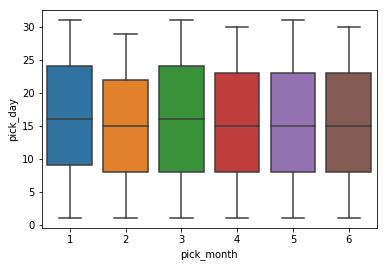

In [56]:
ax = sns.boxplot(x=train["pick_month"], y=train['pick_day'])

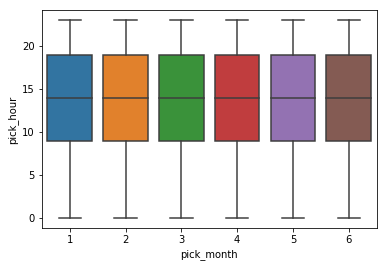

In [57]:
ax = sns.boxplot(x=train["pick_month"], y=train['pick_hour'])

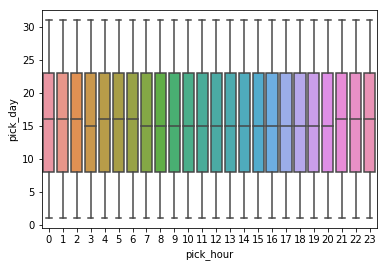

In [58]:
ax = sns.boxplot(x=train["pick_hour"], y=train['pick_day'])

# office hour

In [59]:
labels = ["dawn", "morning", "afternoon", "evening", "night"]
cats1 = pd.cut(train['pick_hour'], 5, labels = labels)
cats2 = pd.cut(test['pick_hour'], 5, labels = labels)
train['office'] = cats1
test['office'] = cats2

In [60]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,uclidean,manhatan,direction,pick_pca0,pick_pca1,drop_pca0,drop_pca1,gaus_pick,gaus_drop,office
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,1.498521,2.248074,174.333195,0.007691,0.017053,-0.009667,0.013695,11,2,evening
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,1.805507,2.997289,-178.051506,0.007677,-0.012371,0.027145,-0.018652,15,0,dawn
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,6.385098,9.073912,-179.629721,0.004803,0.012879,0.034222,-0.039337,19,12,afternoon
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,1.485498,1.752341,-179.872566,0.038342,-0.029194,0.041343,-0.042293,0,12,night
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,1.188588,1.224652,179.990812,-0.002877,0.041748,-0.002380,0.031070,11,14,afternoon


# weekend

In [61]:
train['weekend'] = 1 * ((train["pick_dayofweek"] == 5) | (train["pick_dayofweek"] == 6))
test['weekend'] = 1 * ((test["pick_dayofweek"] == 5) | (test["pick_dayofweek"] == 6))

In [62]:
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,manhatan,direction,pick_pca0,pick_pca1,drop_pca0,drop_pca1,gaus_pick,gaus_drop,office,weekend
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,2.248074,174.333195,0.007691,0.017053,-0.009667,0.013695,11,2,evening,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,2.997289,-178.051506,0.007677,-0.012371,0.027145,-0.018652,15,0,dawn,1
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,9.073912,-179.629721,0.004803,0.012879,0.034222,-0.039337,19,12,afternoon,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,1.752341,-179.872566,0.038342,-0.029194,0.041343,-0.042293,0,12,night,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,1.224652,179.990812,-0.002877,0.041748,-0.002380,0.031070,11,14,afternoon,1


# 3. Modeling

# evaluation metric

[Root Mean Squared Logarithmic Error](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)

$\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Where:
- ϵ is the RMSLE value (score)

- n is the total number of observations in the (public/private) data set,

- pi is your prediction of trip duration, and
- ai is the actual trip duration for i. 
- log(x) is the natural logarithm of x

### data type manipulation
- categorical data convert encoding

In [63]:
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

In [64]:
# train['gaus_pick'] = train['gaus_pick'].astype('object')
# train['gaus_drop'] = train['gaus_drop'].astype('object')
# test['gaus_drop'] = test['gaus_drop'].astype('object')
# train['gaus_drop'] = train['gaus_drop'].astype('object')

# input data shape check

In [65]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)
train = train.drop(['pickup_datetime'], axis=1)
test = test.drop(['pickup_datetime'], axis=1)
print(train.shape, test.shape)

(1458640, 25) (625134, 24)


In [66]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [67]:
X_train = train.drop(['trip_duration'], axis=1)
y_train = train['trip_duration']
y_log = np.log(y_train)

# lightgbm

In [89]:
model_log = lgb.LGBMRegressor(n_estimators=17500, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1).fit(X_train, y_log)

In [90]:
y_pred = model_log.predict(test)

In [91]:
y_exp = np.exp(y_pred)

sub = pd.DataFrame(columns= ['id', 'trip_duration'])
sub['id'] = sample_submission["id"]
sub['trip_duration'] = y_exp
sub.to_csv('sub_lgb_exp1.csv',index=False)

!kaggle competitions submit -c nyc-taxi-trip-duration -f sub_lgb_exp1.csv -m "Message"

#n_estimators=1000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.39475, 0.39786
#n_estimators=1000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.39072, 0.39368
#n_estimators=1500, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38848, 0.39147
#n_estimators=2000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38670, 0.38967
#n_estimators=3000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38499, 0.38761
#n_estimators=4000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38368, 0.38634
#n_estimators=5000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38295, 0.38553
#n_estimators=10000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38206, 0.38433


#top score #top 16%
#n_estimators=15000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38180, 0.38384


#n_estimators=20000, reg_alpha=0.5, reg_lambda=0.5, n_jobs=-1
#0.38195, 0.38401

Successfully submitted to New York City Taxi Trip Duration

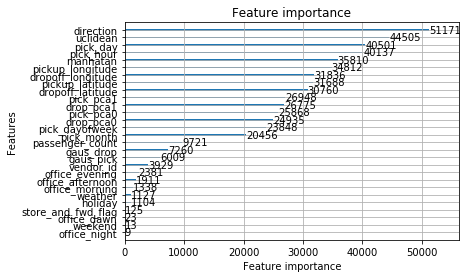

In [92]:
lgb.plot_importance(model_log)

# Cross Validation

In [ ]:
# from sklearn.cross_validation import cross_val_score

In [ ]:
# cross_lgb = cross_val_score(model_log, X_train, y_log, n_jobs=-1)
# cross_lgb

# OLS

In [74]:
OLS_model = sm.OLS(y_log, X_train).fit()
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                 3.540e+04
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:15:42   Log-Likelihood:            -1.4198e+06
No. Observations:             1458640   AIC:                         2.840e+06
Df Residuals:                 1458616   BIC:                         2.840e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
vendor_id              0.0199      0

In [75]:
Y_test = OLS_model.predict(test)
Y_test_exp = np.exp(Y_test)


sub = pd.DataFrame(columns= ['id', 'trip_duration'])
sub['id'] = sample_submission["id"]
sub['trip_duration'] = Y_test_exp
sub.to_csv('submission_OLS.csv',index=False)
!kaggle competitions submit -c nyc-taxi-trip-duration -f submission_OLS.csv -m "Message"

Successfully submitted to New York City Taxi Trip Duration

# Appendix

### 1. degree of decimal
- 0.000001 = 1.11mm

### 2. spatial data analysis
- PCA
- discriminant analysis

### 3. clustering
- K means
- K nearest neighbor
- Expectation Maximization

### 4. ensemble methods
- aggregation
- boosting